In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName("HeartDataAnalysis").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/30 00:15:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
file1 = "heart.csv"
file2 = "heart2.csv"
df1 = spark.read.csv(file1, header=True, inferSchema=True)
df2 = spark.read.csv(file2, header=True, inferSchema=True)

In [10]:
df1.describe().show()
df1.printSchema()
df2.describe().show()
df2.printSchema()

Summary statistics of df1:
+-------+------------------+----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+-------------------+
|summary|               Age| Sex|ChestPainType|         RestingBP|       Cholesterol|          FastingBS|RestingECG|             MaxHR|ExerciseAngina|           Oldpeak|ST_Slope|       HeartDisease|
+-------+------------------+----+-------------+------------------+------------------+-------------------+----------+------------------+--------------+------------------+--------+-------------------+
|  count|               918| 918|          918|               918|               918|                918|       918|               918|           918|               918|     918|                918|
|   mean|53.510893246187365|null|         null|132.39651416122004| 198.7995642701525|0.23311546840958605|      null|136.80936819172112|          null|0.8873638344226581|    null

In [11]:
df2 = df2.withColumnRenamed("Chest pain type", "ChestPainType") \
         .withColumnRenamed("BP", "RestingBP") \
         .withColumnRenamed("FBS over 120", "FastingBS") \
         .withColumnRenamed("EKG results", "RestingECG") \
         .withColumnRenamed("Exercise angina", "ExerciseAngina") \
         .withColumnRenamed("Max HR", "MaxHR") \
         .withColumnRenamed("ST depression", "Oldpeak") \
         .withColumnRenamed("Slope of ST", "ST_Slope") \
         .withColumnRenamed("Heart Disease", "HeartDisease")

In [12]:
df1 = df1.withColumn("Sex", (col("Sex") == "M").cast("int"))
df1 = df1.withColumn("ChestPainType", col("ChestPainType").cast("int"))
df1 = df1.withColumn("FastingBS", col("FastingBS").cast("int"))
df1 = df1.withColumn("RestingECG", col("RestingECG").cast("int"))
df1 = df1.withColumn("ExerciseAngina", (col("ExerciseAngina") == "Y").cast("int"))
df1 = df1.withColumn("ST_Slope", col("ST_Slope").cast("int"))
df2 = df2.withColumn("HeartDisease", (col("HeartDisease") == "Presence").cast("int"))

In [13]:
columns_to_drop = ["Number of vessels fluro", "Thallium"]
df2 = df2.drop(*columns_to_drop)

In [14]:
df_merged = df1.union(df2)


In [15]:
df_merged.printSchema()
df_merged.describe().show()

root
 |-- Age: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- ChestPainType: integer (nullable = true)
 |-- RestingBP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FastingBS: integer (nullable = true)
 |-- RestingECG: integer (nullable = true)
 |-- MaxHR: integer (nullable = true)
 |-- ExerciseAngina: integer (nullable = true)
 |-- Oldpeak: double (nullable = true)
 |-- ST_Slope: integer (nullable = true)
 |-- HeartDisease: integer (nullable = true)

+-------+-----------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|summary|              Age|                Sex|     ChestPainType|         RestingBP|       Cholesterol|          FastingBS|        RestingECG|             MaxHR|     ExerciseAngina|           Oldpeak|          ST_Slope|      HeartDisease|
+-------+------

In [16]:
df_merged.select([col for col in df_merged.columns if col != "HeartDisease"]).describe().show()

+-------+-----------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+
|summary|              Age|                Sex|     ChestPainType|         RestingBP|       Cholesterol|          FastingBS|        RestingECG|             MaxHR|     ExerciseAngina|           Oldpeak|          ST_Slope|
+-------+-----------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+
|  count|             1188|               1188|               270|              1188|              1188|               1188|               270|              1188|               1188|              1188|               270|
|   mean|53.72053872053872| 0.7643097643097643| 3.174074074074074|132.15740740740742|210.35858585858585| 0.213804713

In [17]:
df_merged.filter(df_merged["RestingBP"] == 0).count()


1

+-------+------------------+
|summary|       Cholesterol|
+-------+------------------+
|  count|              1188|
|   mean|210.35858585858585|
| stddev|101.50556295703767|
|    min|                 0|
|    max|               603|
+-------+------------------+



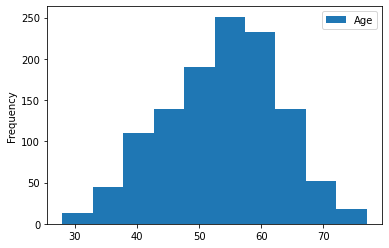

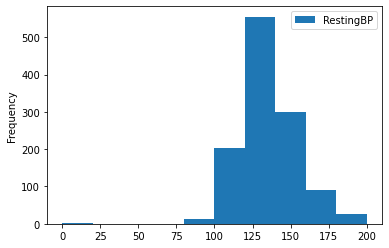

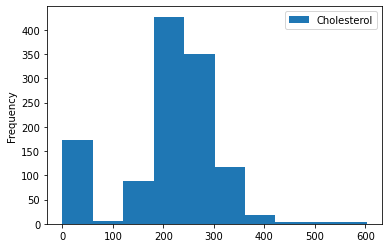

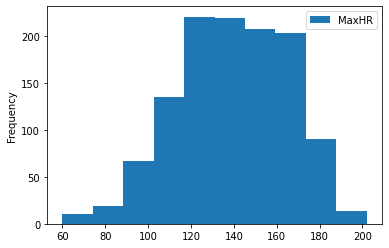

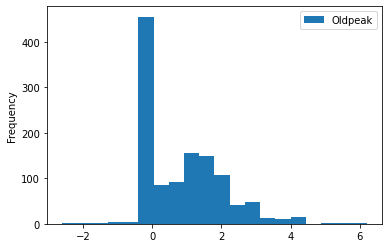

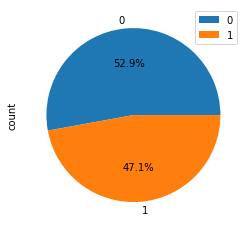

In [19]:
df_merged.select("Age").toPandas().plot.hist()
df_merged.select("RestingBP").toPandas().plot.hist()
df_merged.select("Cholesterol").toPandas().plot.hist()
df_merged.select("MaxHR").toPandas().plot.hist()
df_merged.select("Oldpeak").toPandas().plot.hist(bins=20)
df_merged.groupBy("HeartDisease").count().toPandas().plot.pie(y="count", autopct="%1.1f%%")
df_merged.select("Cholesterol").describe().show()

In [20]:
data = [
    df_merged.select("Age").toPandas(),
    df_merged.select("RestingBP").toPandas(),
    df_merged.select("Cholesterol").toPandas(),
    df_merged.select("MaxHR").toPandas(),
    df_merged.select("Oldpeak").toPandas()
]

In [22]:
print("Columns of df1:", df1.columns)
print("Columns of df2:", df2.columns)

Columns of df1: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']
Columns of df2: ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope', 'HeartDisease']


KeyError: 'Sex'

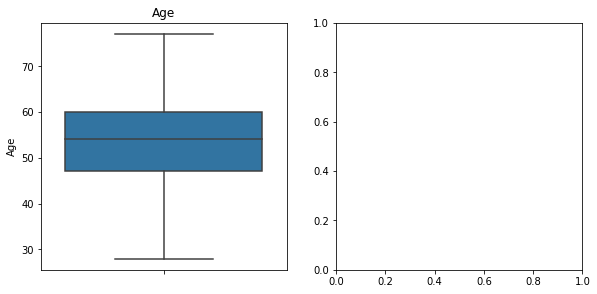

In [23]:
plt.figure(figsize=(15, 10))

for i, col_name in enumerate(df_merged.columns):
    if col_name != "HeartDisease":
        plt.subplot(2, 3, i + 1)
        sns.boxplot(y=data[i][col_name], orient='vertical')
        plt.title(col_name)

plt.show()